In [529]:
import sys
sys.path.insert(0, '../gofher')

import numpy as np
import csv

import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from gofher import run_gofher
from galaxy import galaxy
from matrix import create_centered_mesh_grid
from visualize import visualize
from fits import write_fits
from file_helper import write_csv,check_if_folder_exists_and_create
from spin_parity import read_spin_parity_galaxies_label_from_csv, standardize_galaxy_name

In [530]:
survery_to_use = "panstarrs"

BANDS_IN_ORDER = ['g','r','i','z','y'] #Important: Must stay in order of BLUEST to REDDEST Waveband (Editting this will cause gofher to no longer correctly evaluate redder side of galaxy)
REF_BANDS_IN_ORDER = ['i','z','y','r','g'] #The prefernce each waveband being choosen as refernce band from highest priority to lowest priority

In [531]:
figure_to_run_on = "figure9"

In [532]:
generate_verbose_csv = False
generate_ebm_csv = False
generate_visualization = True
save_visualization = False

In [533]:
#Important: Make sure you update these values:
path_to_catalog_data = "..\\..\\spin-parity-catalog-data"
path_to_output = "..\\..\\gofher-data\\panstarrs\\source_extraction"

In [534]:
def get_fits_path(name,band):
    """the file path of where existing fits files can be found"""
    return os.path.join(path_to_catalog_data,survery_to_use,figure_to_run_on,name,"{}_{}.fits".format(name,band))

def get_color_image_path(name):
    return os.path.join(path_to_catalog_data,survery_to_use,figure_to_run_on,name,"{}_color.jfif".format(name))

def get_path_to_catalog_csv():
    return os.path.join(path_to_catalog_data,"catalog","{}.csv".format(figure_to_run_on))

In [535]:
def get_paper_dark_side_labels():
    return read_spin_parity_galaxies_label_from_csv(get_path_to_catalog_csv())

def get_galaxies():
    return os.listdir(os.path.join(path_to_catalog_data,survery_to_use,figure_to_run_on))

In [536]:
def generate_raw_csvs(gal,path_to_folder=''):
    output_pa = os.path.join(path_to_folder,gal.name)
    check_if_folder_exists_and_create(output_pa)
    
    pos,neg = gal.create_bisection()
    to_output = pos.astype(int) - neg.astype(int)
    to_output *= gal.area_to_diff

    write_fits(os.path.join(output_pa,"{}_raw.fits".format(gal.name)),to_output)

    to_write = []

    for band_pair_key in gal.band_pairs:
        band_pair = gal.band_pairs[band_pair_key]

        write_fits(os.path.join(output_pa,"{}_{}.fits".format(gal.name,band_pair_key)),band_pair.diff_image)

        p = np.logical_and(pos,gal.area_to_diff)
        n = np.logical_and(neg,gal.area_to_diff)
        
        to_write.append(["{}_{}".format(band_pair_key,gal.pos_side_label)] +list(band_pair.diff_image[p]))
        to_write.append(["{}_{}".format(band_pair_key,gal.neg_side_label)] +list(band_pair.diff_image[n]))

    with open(os.path.join(output_pa,"{}_raw.csv".format(gal.name)),'w',newline='') as f:
        writer = csv.writer(f)
        writer.writerows(to_write)

def generate_new_raw_csv(gal: galaxy,path_to_folder=''):
    h = gal.gofher_params.x; k = gal.gofher_params.y; shape = gal.area_to_diff.shape
    theta = gal.gofher_params.theta
    xv, yv = create_centered_mesh_grid(h,k,shape)

    el_maj_axis_pixel_coord = (xv*np.cos(theta)+yv*np.sin(theta))[gal.area_to_diff]
    el_min_axis_pixel_coord = (-xv*np.sin(theta)+yv*np.cos(theta))[gal.area_to_diff]
    data = gal.band_pairs['r-y'].diff_image[gal.area_to_diff]

    to_write = np.array([el_maj_axis_pixel_coord,el_min_axis_pixel_coord,data]).transpose()

    plt.imshow((xv*np.cos(theta)+yv*np.sin(theta))*gal.area_to_diff)
    plt.show()
    plt.imshow((-xv*np.sin(theta)+yv*np.cos(theta))*gal.area_to_diff)
    plt.show()

    #pa = os.path.join(path_to_folder,"{}_r-y.csv".format(gal.name))
    #print(pa)
    #np.savetxt(pa, to_write, delimiter=",")

In [537]:
def run_gofher_on_catalog(gals_to_run_on = []):
    paper_labels = get_paper_dark_side_labels()

    verbose_header = []
    verbose_rows = []

    ebm_header = []
    ebm_rows = []

    i = 1


    for name in get_galaxies():
        if len(gals_to_run_on) > 0 and name not in gals_to_run_on:
            continue

        if standardize_galaxy_name(name) not in paper_labels:
            print("skippimg",name)
            continue

        print(name, i,"of",len(get_galaxies()))

        #try:
        if True:
            paper_label = paper_labels[standardize_galaxy_name(name)]
            gal = run_gofher(name,get_fits_path,BANDS_IN_ORDER,REF_BANDS_IN_ORDER, paper_label)

            #pa = "/Users/cora-at-work/Desktop/raw_diff_output"
            pa = "C:\\Users\\school\\Desktop\\raw_diff_output"
            #generate_raw_csvs(gal,pa)
            generate_new_raw_csv(gal,pa)
        #except Exception as e:
        #print(e)
        i += 1


In [538]:
figure_10_gals = ["NGC3726"]
figure_9_gals = ["NGC3992",
                "NGC2525",
                "NGC628",
                "NGC278",
                "NGC3344",
                "NGC3346",
                "NGC3445",
                "NGC3642",
                "NGC4351",
                "NGC4490",
                "NGC4701",
                "NGC5218",
                "NGC5669",
                "NGC7549",
                "PGC06855",
                "PGC07826",
                "PGC20938",
                "PGC23913",
                "PGC27792",
                "PGC49906",
                "UGC10796",
                "UGC1081",
                "UGC12391",
                "UGC1529",
                "UGC1635",
                "UGC1908",
                "UGC312",
                "UGC3140",
                "UGC3997",
                "UGC4036",
                "UGC4458",
                "UGC448",
                "UGC4555",
                "UGC4622",
                "UGC463",
                "UGC4936",
                "UGC6903",
                "UGC6918",
                "UGC7244",
                "UGC8196",
                "UGC9965"]

additional_gals = ['NGC1',
                   'NGC4536',
                   'NGC2207',
                   'NGC2805',
                   'NGC5135',
                   'UGC12274']

additional_gals = ['NGC3887',
                   'NGC1385']

additional_gals = ['NGC1614']

NGC2525 1 of 317


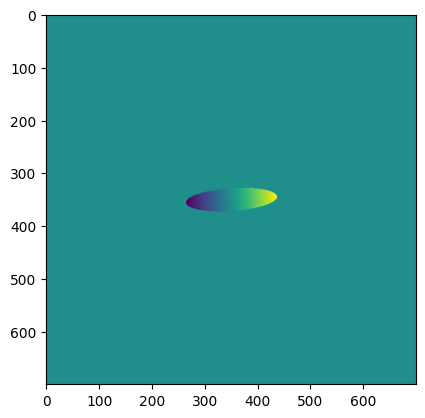

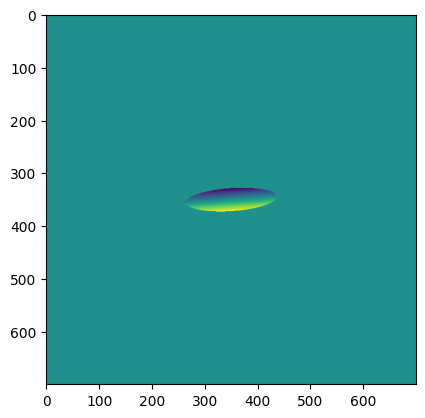

NGC278 2 of 317


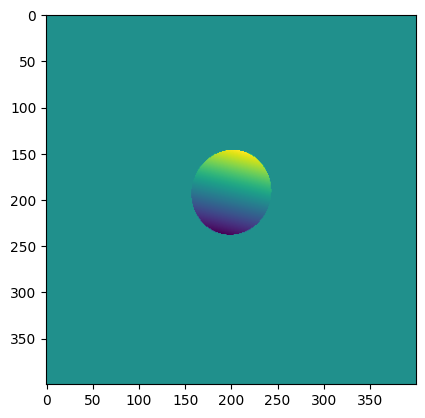

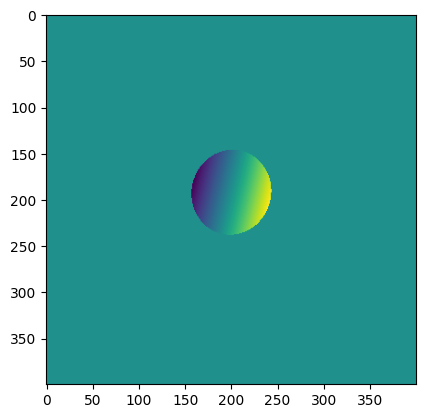

NGC3344 3 of 317


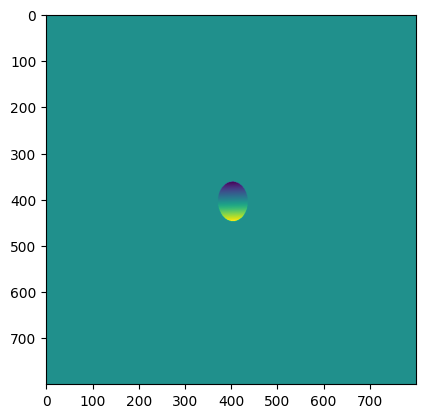

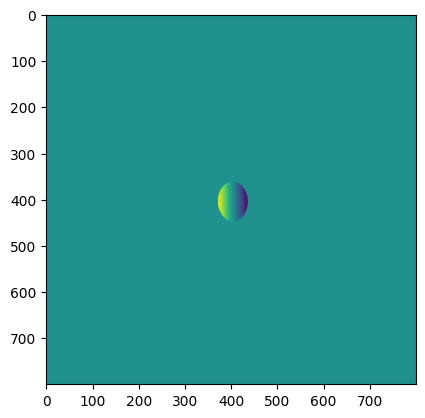

NGC3346 4 of 317


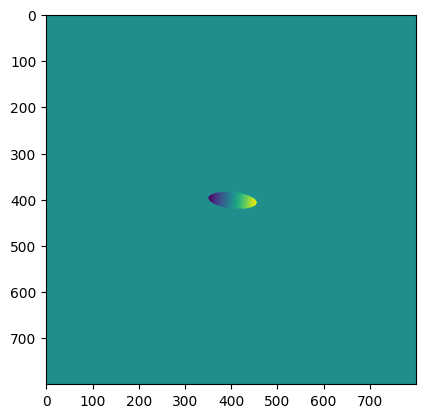

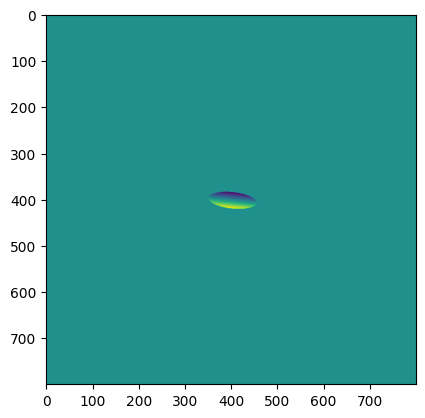

NGC3445 5 of 317


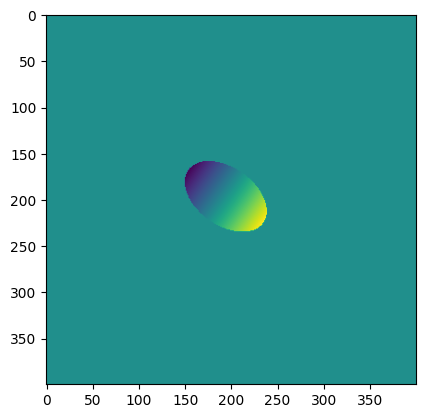

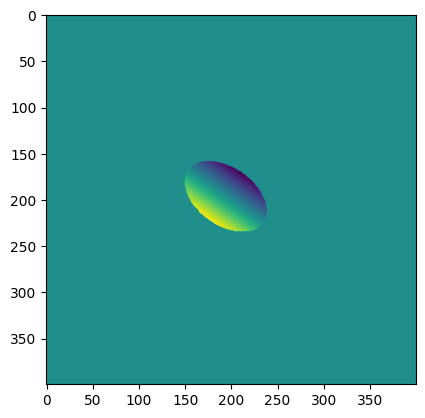

NGC3642 6 of 317


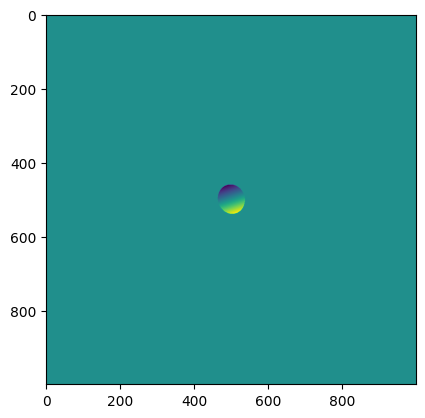

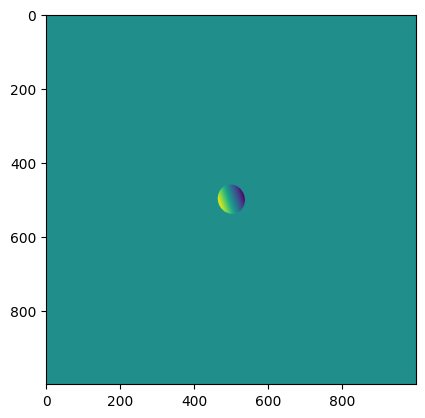

NGC3992 7 of 317


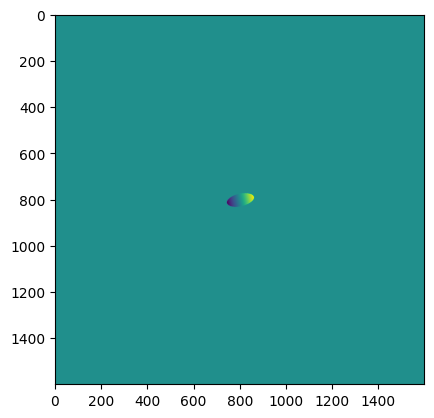

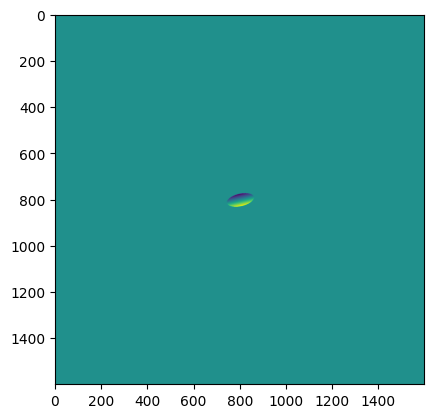

NGC4351 8 of 317


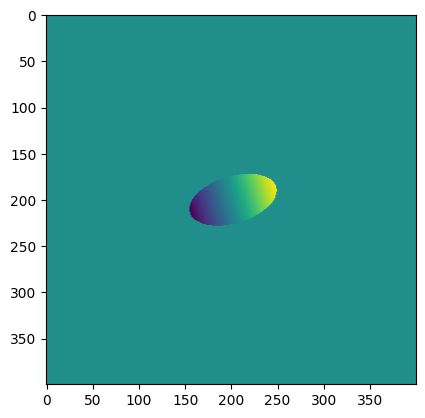

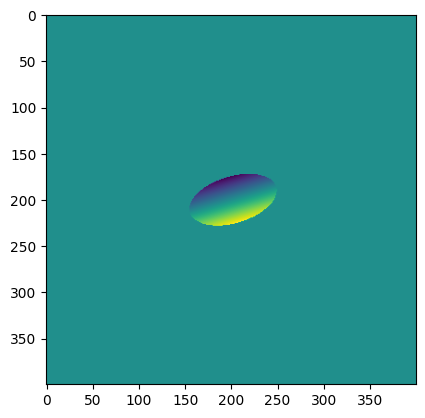

NGC4490 9 of 317


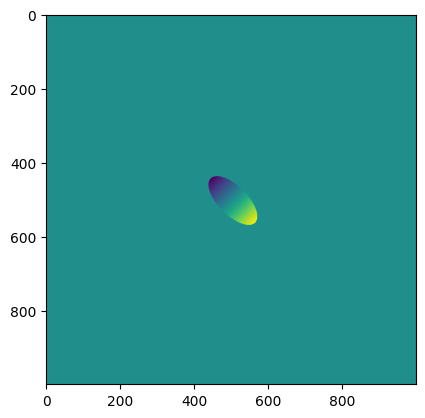

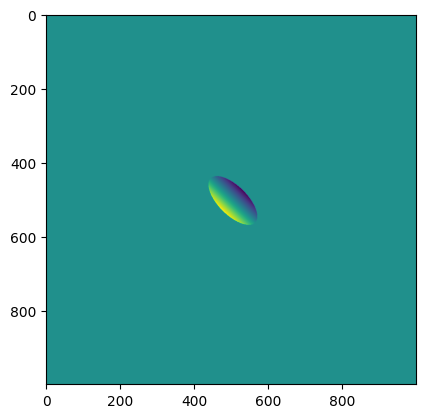

NGC4701 10 of 317


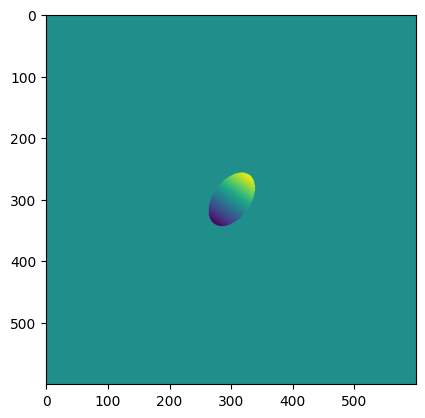

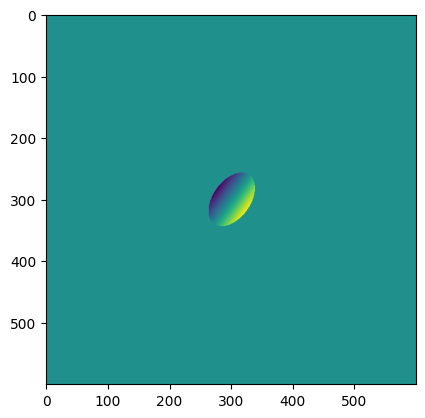

NGC5218 11 of 317


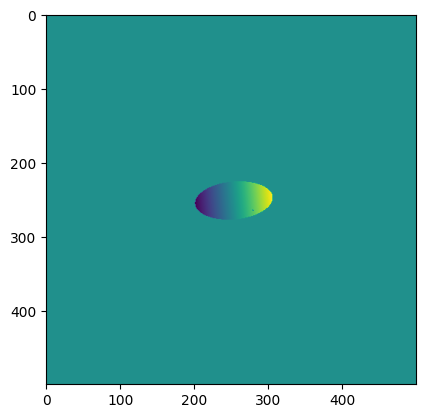

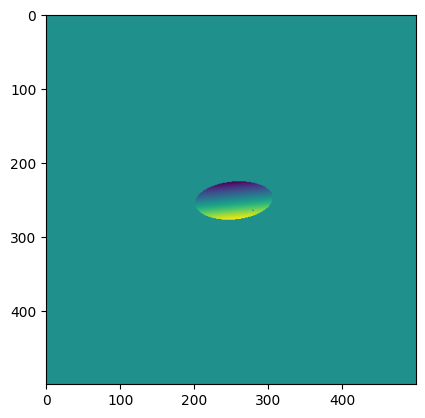

NGC5669 12 of 317


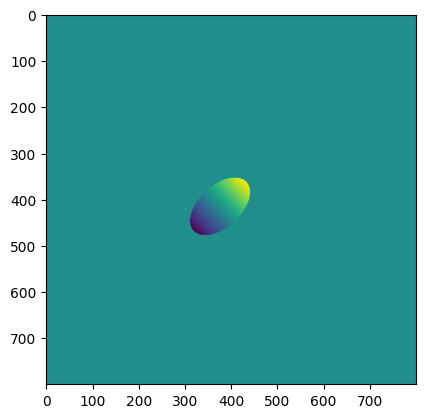

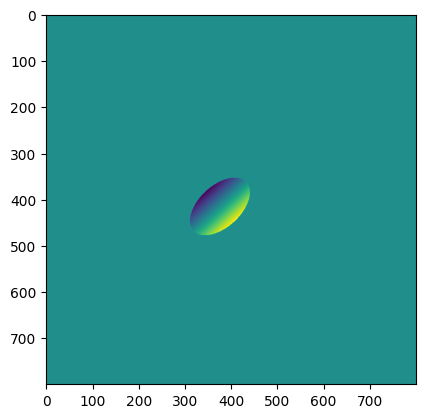

NGC628 13 of 317


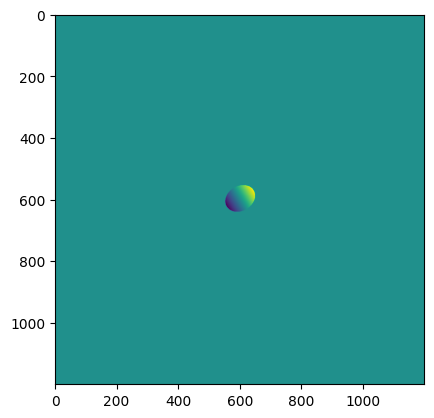

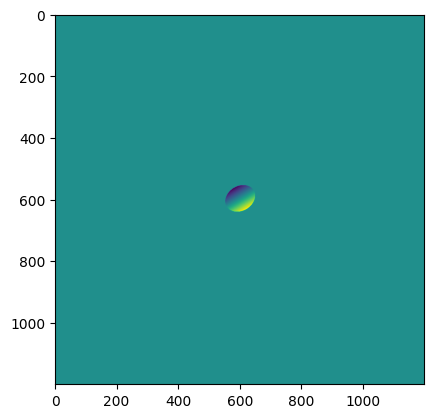

NGC7549 14 of 317


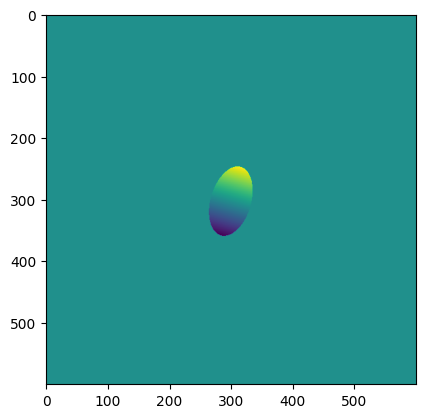

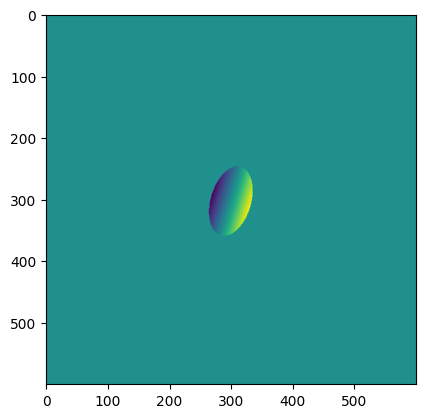

PGC06855 15 of 317


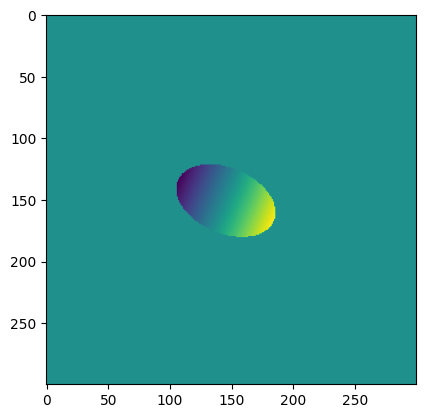

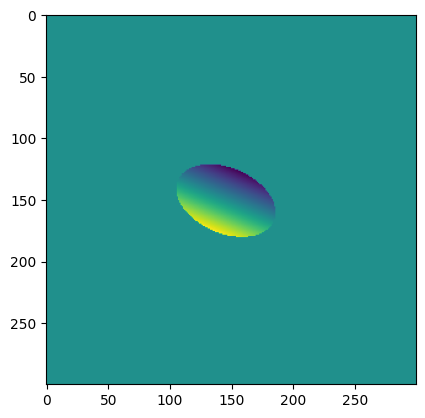

PGC07826 16 of 317


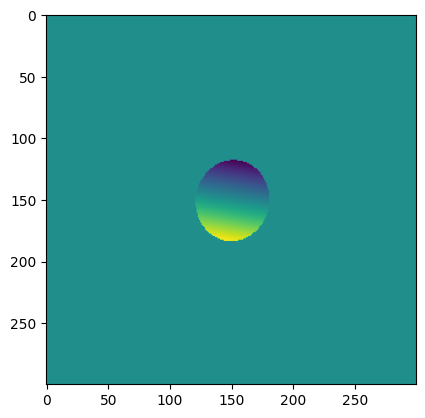

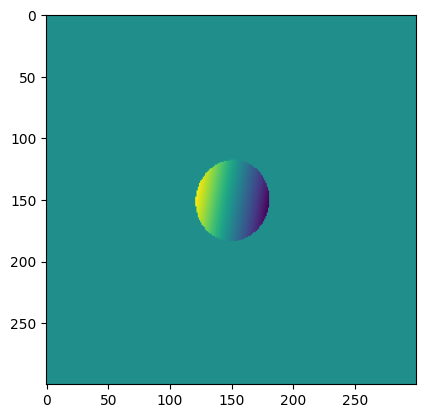

PGC20938 17 of 317


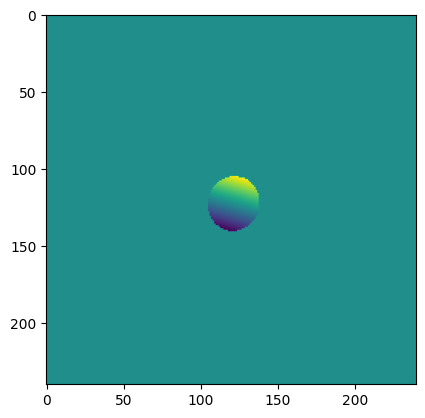

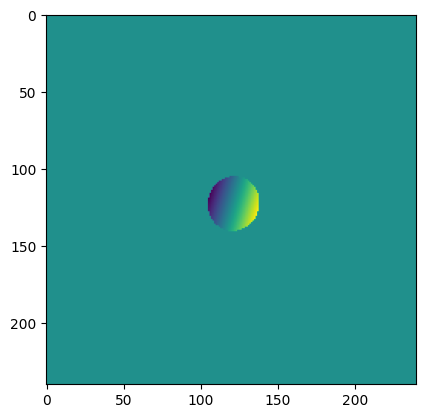

PGC23913 18 of 317


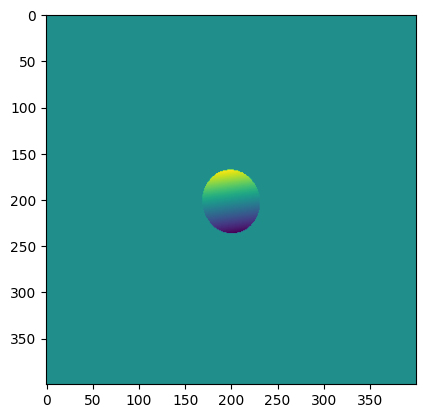

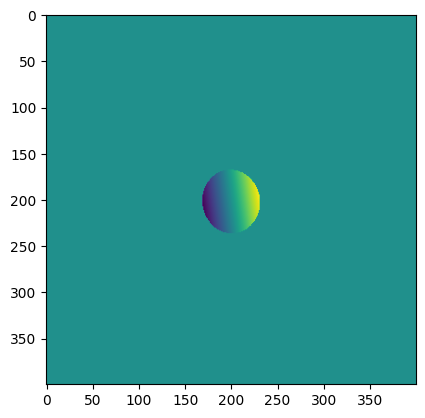

PGC27792 19 of 317


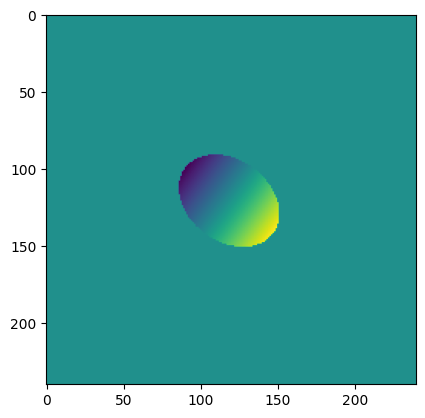

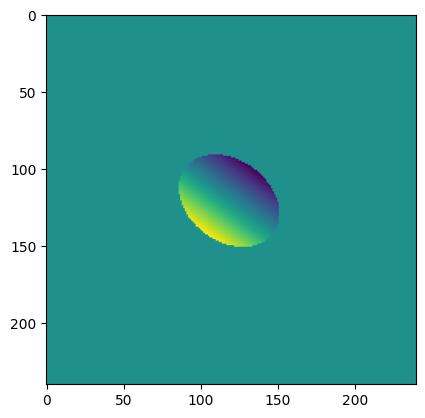

PGC49906 20 of 317


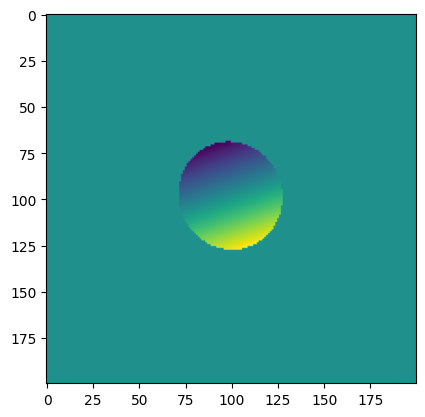

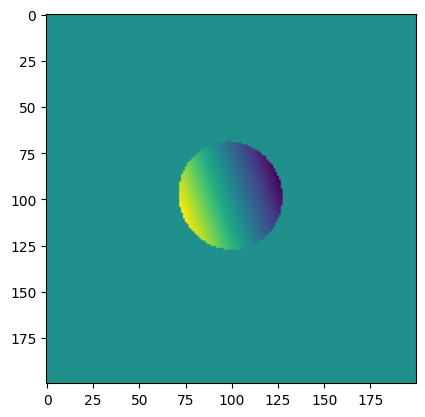

UGC10796 21 of 317


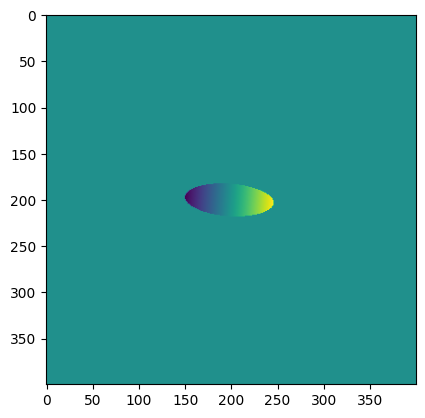

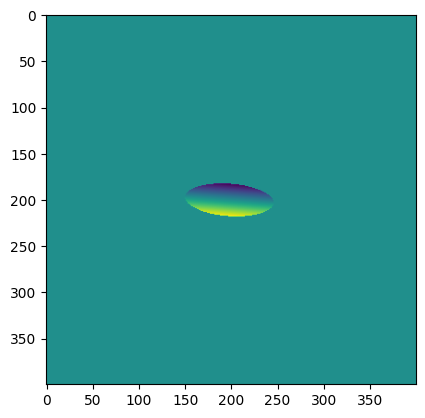

UGC1081 22 of 317


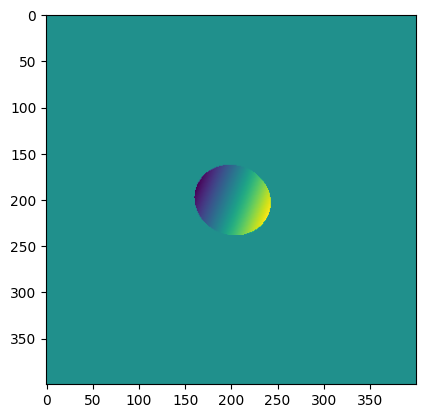

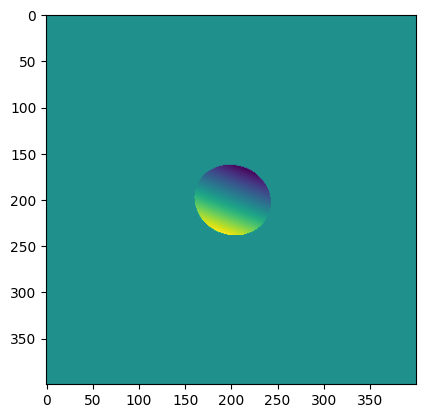

UGC12391 23 of 317


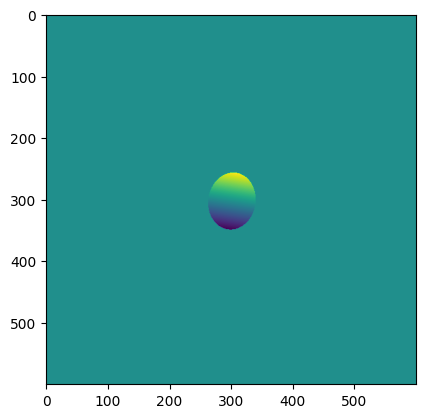

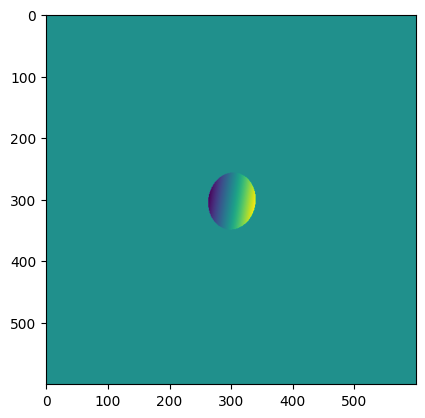

UGC1529 24 of 317


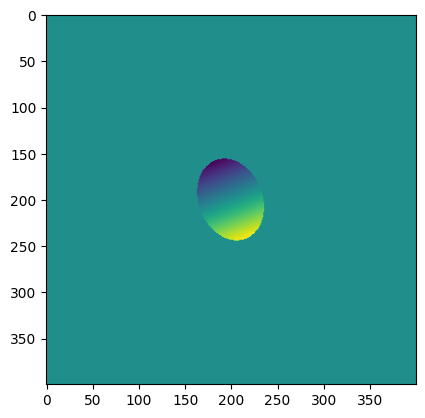

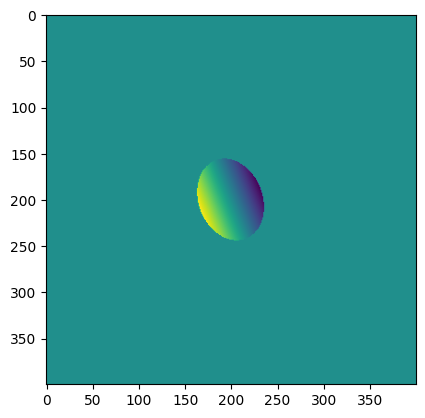

UGC1635 25 of 317


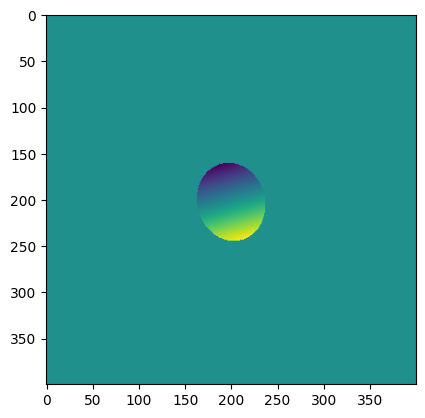

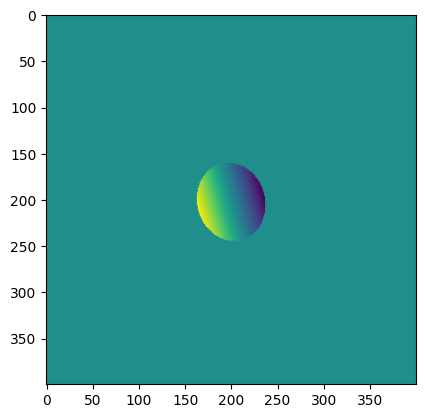

UGC1908 26 of 317


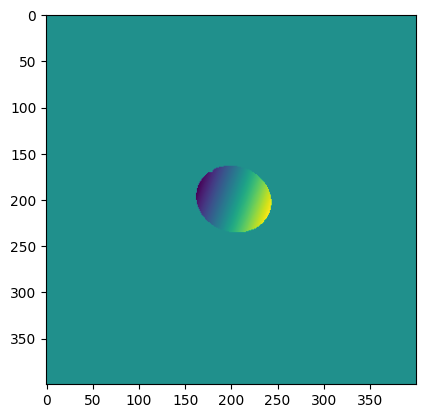

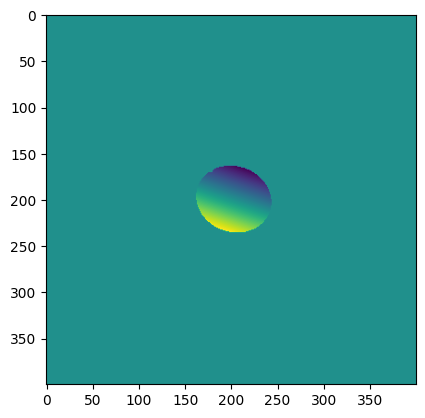

UGC312 27 of 317


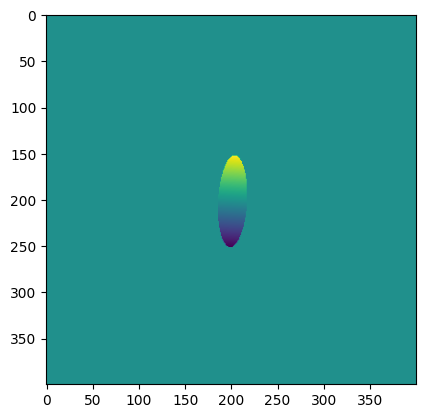

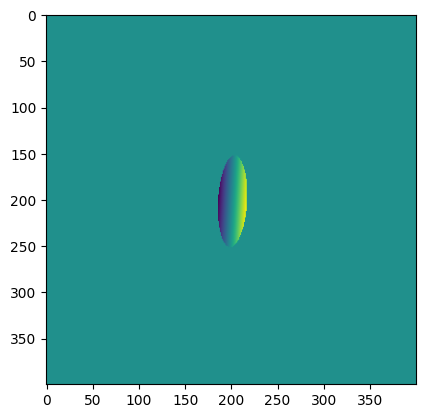

UGC3140 28 of 317


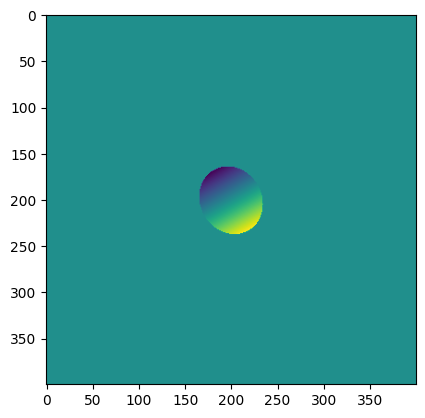

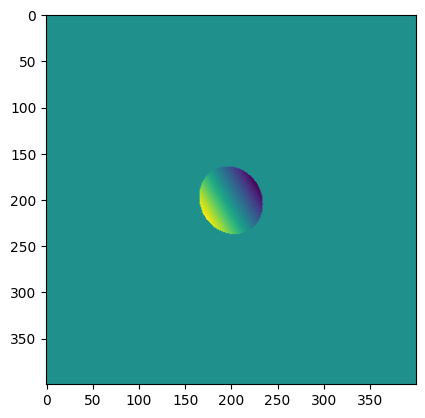

UGC3997 29 of 317


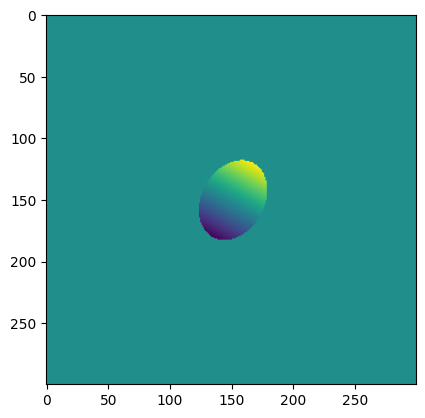

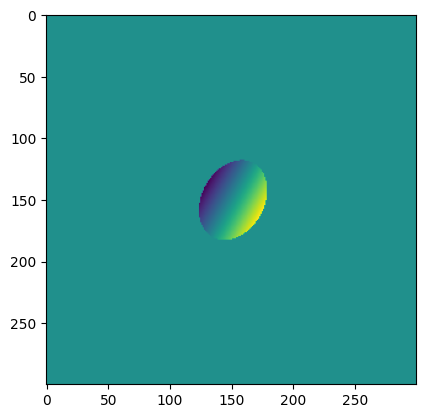

UGC4036 30 of 317


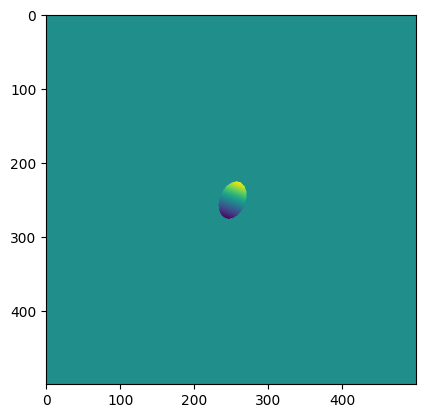

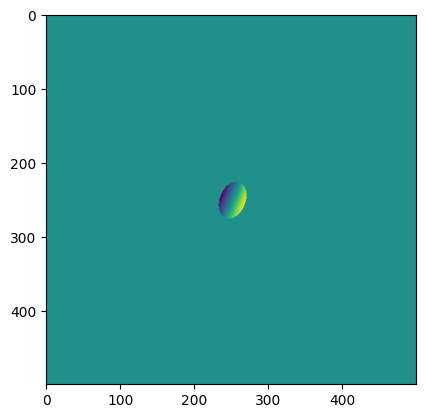

UGC4458 31 of 317


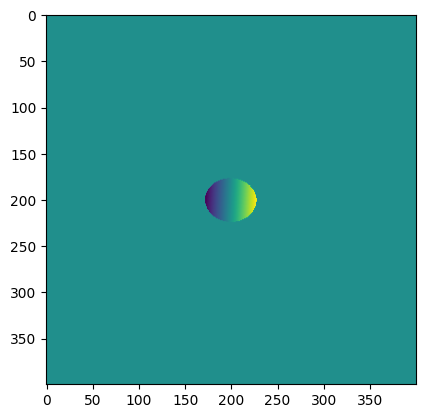

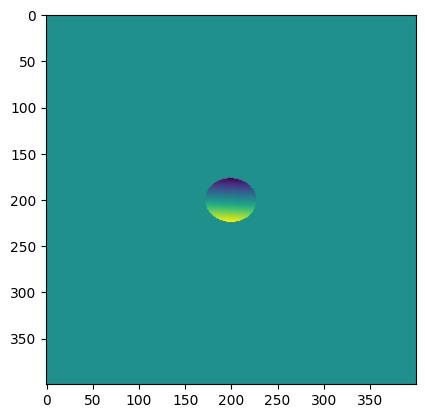

UGC448 32 of 317


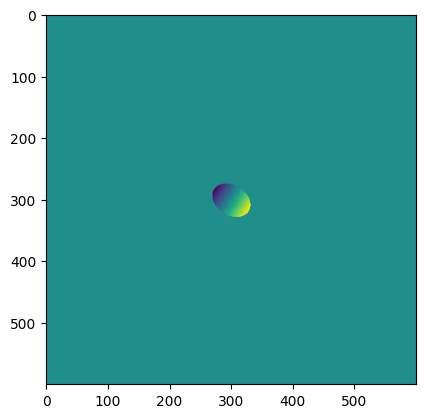

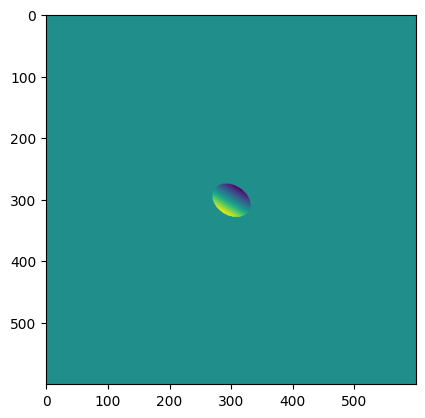

UGC4555 33 of 317


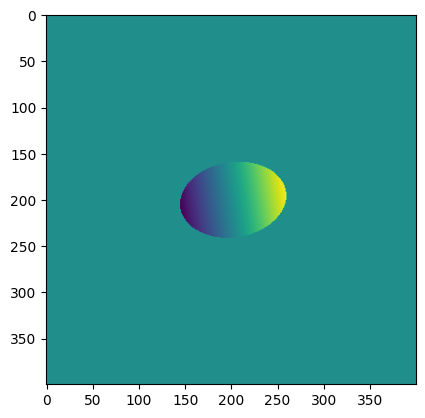

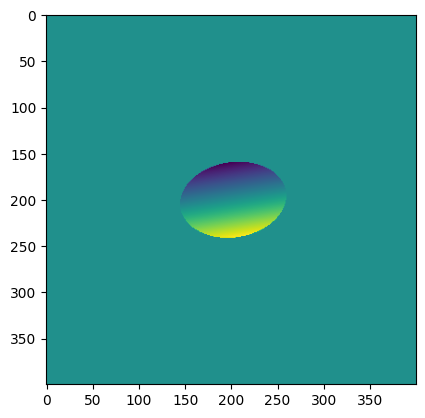

UGC4622 34 of 317


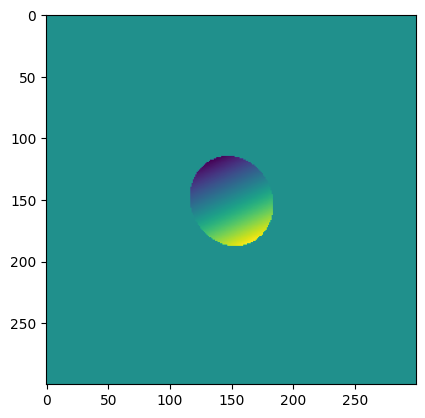

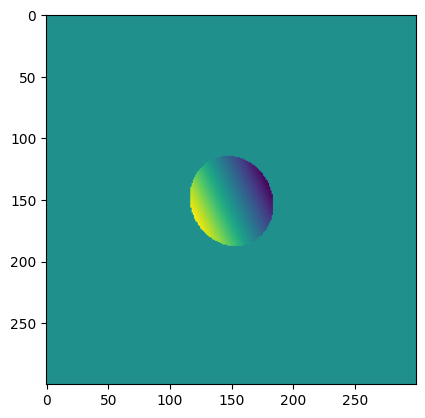

UGC463 35 of 317


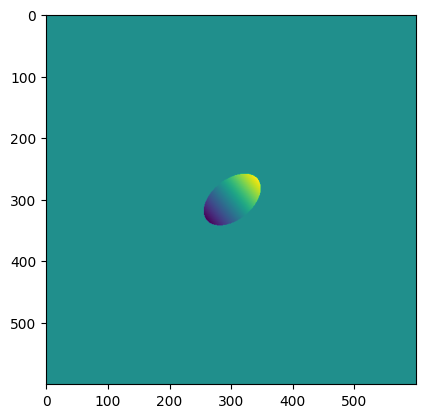

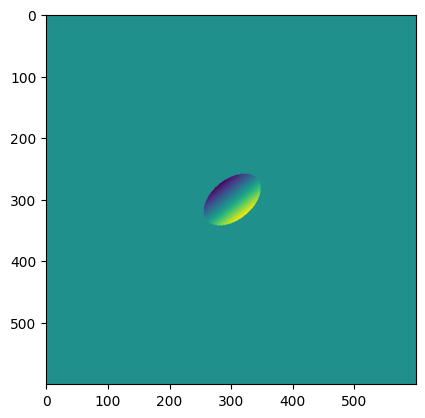

UGC4936 36 of 317


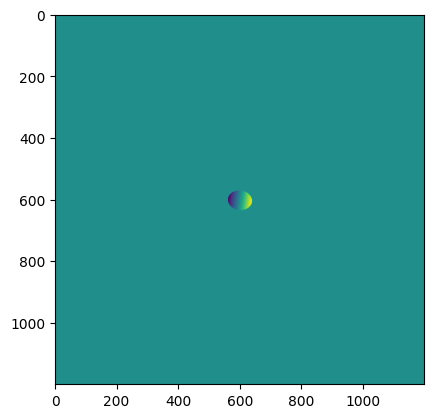

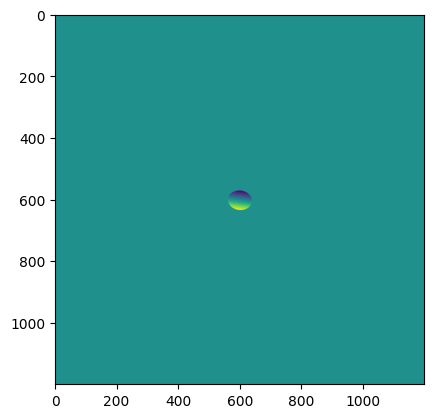

UGC6903 37 of 317


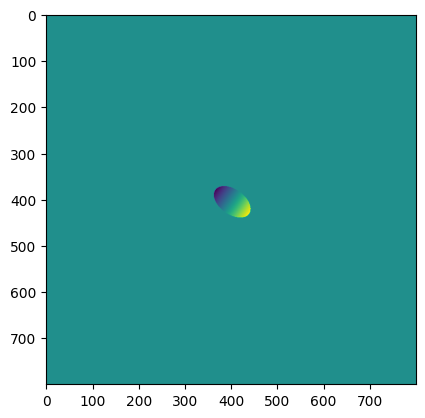

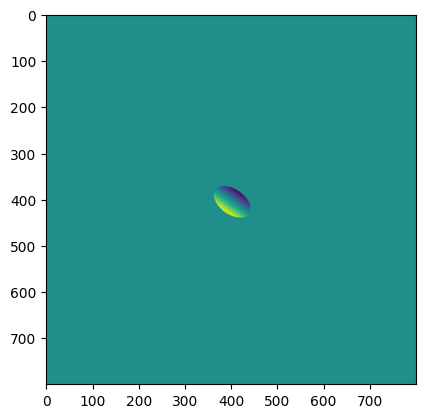

UGC6918 38 of 317


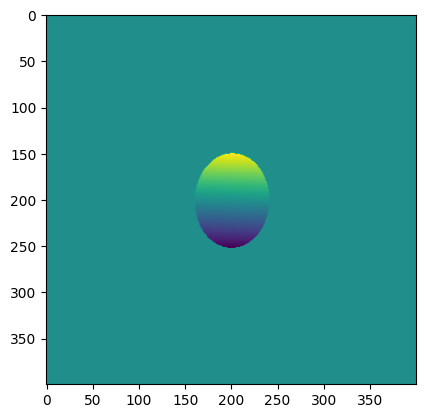

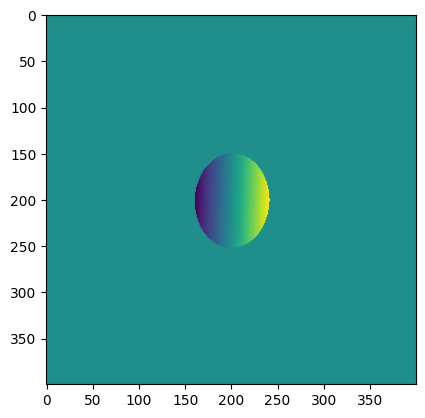

UGC7244 39 of 317
Error fitting sersic, using inital_gofher_parameters from sep


c:\Users\school\Desktop\github\gofher\gofher_env\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\school\Desktop\github\gofher\gofher_env\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\school\Desktop\github\gofher\gofher_env\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\school\Desktop\github\gofher\gofher_env\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\school\Desktop\github\gofher\gofher_env\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


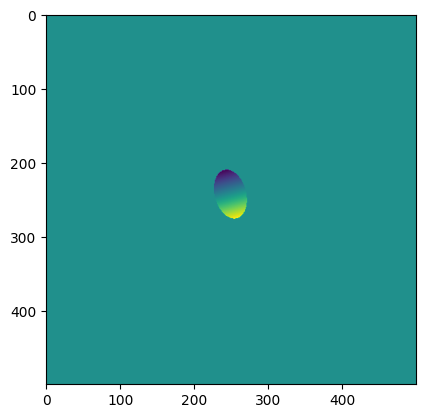

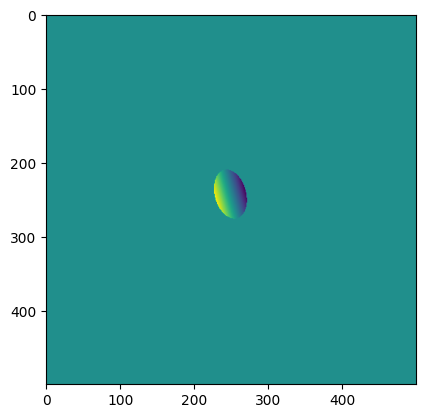

UGC8196 40 of 317


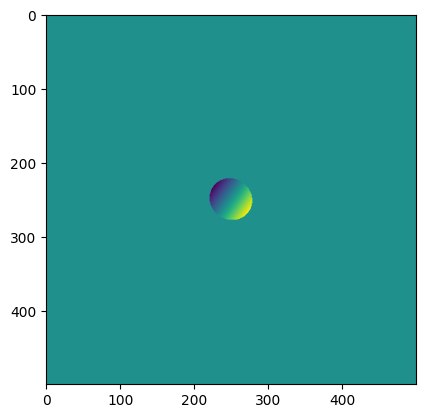

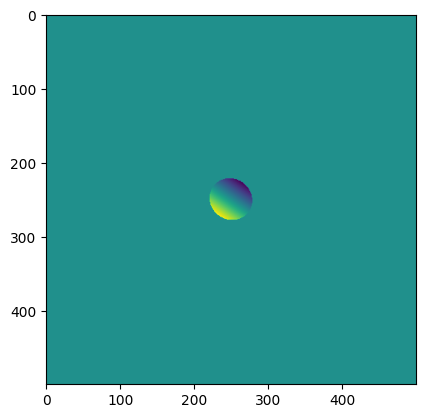

UGC9965 41 of 317


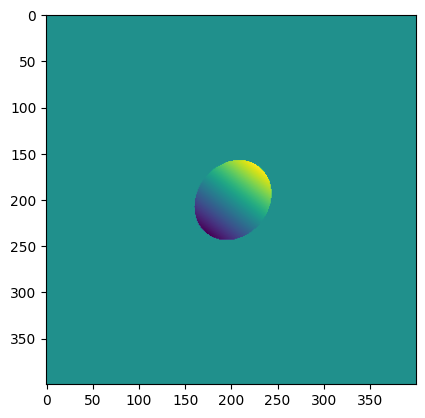

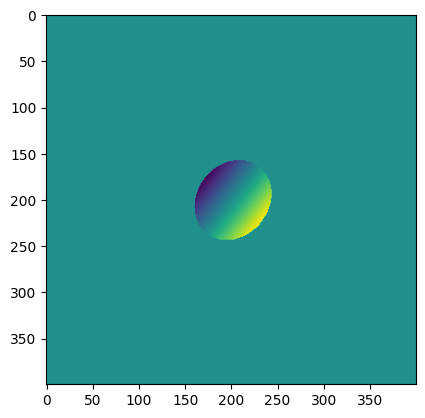

In [539]:
if not os.path.exists(path_to_catalog_data):
    raise ValueError("The path to the catalog is not found {} - make sure you update path_to_catalog_data".format(path_to_catalog_data))


run_gofher_on_catalog(figure_9_gals)
#generate_new_raw_csv(figure_10_gals)